In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from finta import TA          #  Common financial technical indicators implemented in Pandas
import keras                  # Deep learning library for tensorflow (and theano)
import tensorflow as tf       # machine learning library
from tensorflow import keras
#import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History 
from sklearn.metrics import mean_squared_error
import sklearn
from sklearn.preprocessing import MinMaxScaler
import random as python_random

ImportError: cannot import name 'keras' from 'tensorflow' (unknown location)

In [42]:
! pip install tensorflow --upgrade
#! pip install keras --upgrade

  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.8 MB/s eta 0:00:00
  Obtaining dependency information for h5py>=2.9.0 from https://files.pythonhosted.org/packages/8d/70/2b0b99507287f66e71a6b2e66c5ad2ec2461ef2c534668eef96c3b48eb6d/h5py-3.10.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.4 MB/s eta 0:00:00
  Obtaining dependency information for protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3 from https://files.pythonhosted.org/packages/e6/db/7b2edc72807d45d72f9db42f3eb86ddaf37f9e55d923159b1dbfc9d835bc/protobuf-4.25.1-cp37-abi3-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for termcolor>=1.1.0 from https://files.pythonhosted.org/packages/d9/5f/8c716e47b3a50cb

In [1]:
#! pip install keras==2.15.0
! pip show tensorflow
! pip show keras

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/lennartmuller/anaconda3/lib/python3.11/site-packages
Requires: tensorflow-macos
Required-by: 
Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /Users/lennartmuller/anaconda3/lib/python3.11/site-packages
Requires: 
Required-by: tensorflow-macos


In [15]:
# CONVERT DATETIME IT TO A STRING WITH YYYY-MM-DD FORMAT (YFINANCE EXPECTS THAT FORMAT)
start_date = datetime(2020, 12, 20).strftime('%Y-%m-%d')
end_date = datetime(2023, 12, 20).strftime('%Y-%m-%d')

In [10]:
stock_df = yf.download("AAPL", start=start_date, end=end_date)
print(stock_df.head())

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-12-21  125.019997  128.309998  123.449997  128.229996  126.004639   
2020-12-22  131.610001  134.410004  129.649994  131.880005  129.591309   
2020-12-23  132.160004  132.429993  130.779999  130.960007  128.687271   
2020-12-24  131.320007  133.460007  131.100006  131.970001  129.679733   
2020-12-28  133.990005  137.339996  133.509995  136.690002  134.317841   

               Volume  
Date                   
2020-12-21  121251600  
2020-12-22  168904800  
2020-12-23   88223700  
2020-12-24   54930100  
2020-12-28  124486200  


In [11]:
# On-balance volume (OBV) is a technical trading momentum indicator that uses volume flow to predict changes in stock price
# Adding of on balance volume to dataframe

def obv(stock_df):
    # create a new empty DataFrame and then copying the 'Adj Close' column from the stock_df
    new_df = pd.DataFrame()
    new_df = stock_df[['Adj Close']].copy()

    obv_list = [0]  # list for the stored calculated OBV values
    accumulated_volume = 0  # accumulate the volume based on price changes

    # Comparing the adjusted close price with the previous day. If the price has increased, the day's volume is added to 'accumulated_volume'. If the price has decreased, the day's volume is subtracted from 'accumulated_volume'
    for i in range(1, len(new_df)):
        if stock_df['Adj Close'].iloc[i] > stock_df['Adj Close'].iloc[i - 1]:  # add volume
            accumulated_volume += stock_df['Volume'].iloc[i]
        elif stock_df['Adj Close'].iloc[i] < stock_df['Adj Close'].iloc[i - 1]:  # subtract volume 
            accumulated_volume -= stock_df['Volume'].iloc[i]
        obv_list.append(accumulated_volume)

    new_df['OBV'] = obv_list  # Creating a new 'OBV' column in the dataframe

    # Find the minimum value of the OBV and subtract it from all OBV values to normalize them (starting from zero)
    # Then, apply a logarithmic transformation to the OBV values 
    minimum = min(new_df['OBV'])
    new_df['OBV'] = new_df['OBV'] - minimum
    new_df['OBV'] = (new_df['OBV'] + 1).transform(np.log)

    return new_df

# Note: A positive volume pressure would result in higher prices as the demand surges, and likewise a negative volume pressure would eventually result in lower prices.

In [12]:
# Adding technical indicators to dataframe --> Exponential moving average (EMA) and Bollinger Band (BB)

def add_technical_indicators(new_df):
    edited_df = pd.DataFrame()

    # copying the columns of stock_df
    edited_df['open'] = stock_df['Open']
    edited_df['high'] = stock_df['High']
    edited_df['low'] = stock_df['Low']
    edited_df['close'] = stock_df['Close']
    edited_df['volume'] = stock_df['Volume']

    ema = TA.EMA(edited_df, period=20)  # Calculate the Exponential Moving Average (EMA) 
    bb = TA.BBANDS(edited_df, period=20)  # Calculate Bollinger Bands (BB)

    #print(bb)  # just for debugging purposes (delete later) --> first 20 values NaN, because of period=20

    # Adding EMA & BB columns to data frame
    new_df['Exponential_moving_average'] = ema.copy()
    new_df = pd.concat([new_df, bb], axis=1)

    for i in range(len(new_df)):
        new_df['BB_MIDDLE'].iloc[i] = new_df['Exponential_moving_average'].iloc[i]

    if i != 0:
        higher = new_df['BB_MIDDLE'].iloc[i] + 2 * new_df['Adj Close'].rolling(i + 1).std().iloc[i]
        lower = new_df['BB_MIDDLE'].iloc[i] - 2 * new_df['Adj Close'].rolling(i + 1).std().iloc[i]
        new_df['BB_UPPER'].iloc[i] = higher
        new_df['BB_LOWER'].iloc[i] = lower
    else:
        new_df['BB_UPPER'].iloc[i] = new_df['BB_MIDDLE'].iloc[i]
        new_df['BB_LOWER'].iloc[i] = new_df['BB_MIDDLE'].iloc[i]
    return new_df


In [13]:
add_technical_indicators(obv(stock_df))

,Adj Close,OBV,Exponential_moving_average,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,,
2020-12-21,126.004639,21.020569,128.229996,NaN,128.229996,NaN
2020-12-22,129.591309,21.138766,130.146251,NaN,130.146251,NaN
2020-12-23,128.687271,21.078773,130.445057,NaN,130.445057,NaN
2020-12-24,129.679733,21.116547,130.885285,NaN,130.885285,NaN
2020-12-28,134.317841,21.197212,132.289397,NaN,132.289397,NaN
...,...,...,...,...,...,...
2023-12-13,197.960007,21.432689,190.970260,196.684054,190.970260,186.568946
2023-12-14,198.110001,21.465036,191.650235,197.663336,191.650235,186.599665
2023-12-15,197.570007,21.402006,192.214023,198.435782,192.214023,186.613218


In [14]:
def train_test_split_preparation(new_df, train_split):
    
    #history_points = 30  # Using the past 30 days of data to predict the next day
    
    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split)

    train_data = new_df[:train_indices]
    test_data = new_df[train_indices:]
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    test_data = test_data.reset_index()
    train_data = train_data.reset_index()
    train_data = train_data.drop(columns=['Date'])
    test_data = test_data.drop(columns=['Date'])
    
    normaliser = MinMaxScaler()
    train_normalised_data = normaliser.fit_transform(train_data)
    test_normalised_data = normaliser.transform(test_data)

    x_train = np.array([train_normalised_data[:,0:][i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
    y_train = np.expand_dims(y_train, -1)

    y_normaliser = MinMaxScaler()
    next_day_close_values = np.array([train_data['Adj Close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1)

    y_normaliser.fit(next_day_close_values)

    x_test = np.array([test_normalised_data[:,0:][i  : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
    
    y_test = np.array([test_data['Adj Close'][i + history_points].copy() for i in range(len(test_data) - history_points)])
    
    y_test = np.expand_dims(y_test, -1)

    return x_train, y_train, x_test, y_test, y_normaliser

In [15]:
def lstm_model(x_train, y_train, history_points):
    
    #Setting of seed (to maintain constant result)
    tf.random.set_seed(42)
    np.random.seed(42)
    python_random.seed(42)
    
    lstm_input = Input(shape=(history_points, 6), name='lstm_input') # '6' number of features --> Open, High, Low, Close, Adj Close, Volume

    inputs = LSTM(21, name='first_layer')(lstm_input) # 21 --> Number of Units (Neurons) in the NN
    output = Dense(1, name='output', activation='linear')(inputs) # The output of the LSTM layer is passed to a Dense layer with a single unit, which is suitable for regression tasks or when predicting a single continuous value

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr = 0.0009) # optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively based on training data
    model.compile(optimizer=adam, loss='mse')
    model.fit(x=x_train, y=y_train, batch_size=13, epochs=51, shuffle=True, validation_split = 0.1)

    return model

In [16]:
if __name__ == "__main__":
    
    train_split = 0.7
    
    history_points = 30
    
    new_df = obv(stock_df)

    new_df = add_technical_indicators(new_df)
    
    x_train, y_train, x_test, y_test, y_reverse_normaliser = train_test_split_preparation(new_df, train_split)

    model = lstm_model(x_train, y_train, history_points)

    y_pred = model.predict(x_test)
    y_pred = y_reverse_normaliser.inverse_transform(y_pred)

    real = plt.plot(y_test, label='Actual Price')
    pred = plt.plot(y_pred, label='Predicted Price')

    plt.gcf().set_size_inches(12, 8, forward=True)
    plt.title('Plot of real price and predicted price against number of days')
    plt.xlabel('Number of days')
    plt.ylabel('Adjusted Close Price($)')

    plt.legend(['Actual Price', 'Predicted Price'])
    
    print("RMSE: ")
    print(mean_squared_error(y_test, y_pred))
 
    plt.show()  

/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

AttributeError: module 'tensorflow' has no attribute 'random'

In [10]:
# Finding the optimal number of epochs: (Manually checking the values worked better)
# The increase in the number of epochs would reduce the error but too many epochs would result in the model learning the noise of the train data
# One needs to pay attention to the validation loss, and stop when it is at the lowest point as beyond that, we are overfitting our features just to increase our accuracy
    
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # patience=20 --> run until the validation accuracy does not improve for 20 consecutive epochs (stops after 41 epochs)
model.fit(x_train, y_train, epochs=1000, validation_split=0.1, callbacks=[early_stopping])

ModuleNotFoundError: No module named 'tensorflow.compat'

In [389]:
# Predicting the stock price for the next day

# Extract the last 'history_points' days of data
last_days = stock_df[-history_points:]

# Normalize the Input Data --> You need to apply the same transformations as you did for your training data
normaliser = MinMaxScaler()
last_days_scaled = normaliser.fit_transform(last_days)

# Reshape the data to match the input shape of the LSTM model
x_to_predict = np.array([last_days_scaled])
x_to_predict = np.reshape(x_to_predict, (1, history_points, 6))

# Make the Prediction
predicted_stock_price = model.predict(x_to_predict)

# Inverse Transform the Prediction
predicted_stock_price = y_reverse_normaliser.inverse_transform(predicted_stock_price)

# The predicted stock price
print(stock_df.loc['2023-12-19', 'Adj Close'])
print("Predicted stock price for 2023-12-20:", predicted_stock_price[0,0])

1/1 [==============================] - 0s 8ms/step
196.94000244140625
Predicted stock price for 2023-12-20: 171.02237


/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

In [390]:
apple = yf.download("AAPL", start='2023-12-20', end='2023-12-22')
apple

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800
2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500


In [391]:
goog = yf.download("GOOG", start=start_date, end=end_date)
print(goog.head())

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-21  85.675499  87.042503  84.949997  86.968498  86.968498  36568000
2020-12-22  86.721497  86.870247  85.628754  86.175003  86.175003  18734000
2020-12-23  86.405502  87.399498  86.251999  86.619003  86.619003  20676000
2020-12-24  86.750000  87.300003  86.455498  86.942497  86.942497   6936000
2020-12-28  87.581749  89.536400  87.316750  88.804497  88.804497  27860000


Epoch 1/51


/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

34/34 [==============================] - 1s 9ms/step - loss: 0.0954 - val_loss: 0.0706
Epoch 2/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0155 - val_loss: 0.0212
Epoch 3/51
 1/34 [..............................] - ETA: 0s - loss: 0.0136

2024-01-03 17:15:27.212018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 17:15:27.212610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 17:15:27.213349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 4/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 5/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 6/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 7/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 8/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 11/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 12/51
34/34 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 13/51
34/34 [=========

2024-01-03 17:15:33.043043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 17:15:33.043536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 17:15:33.043984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

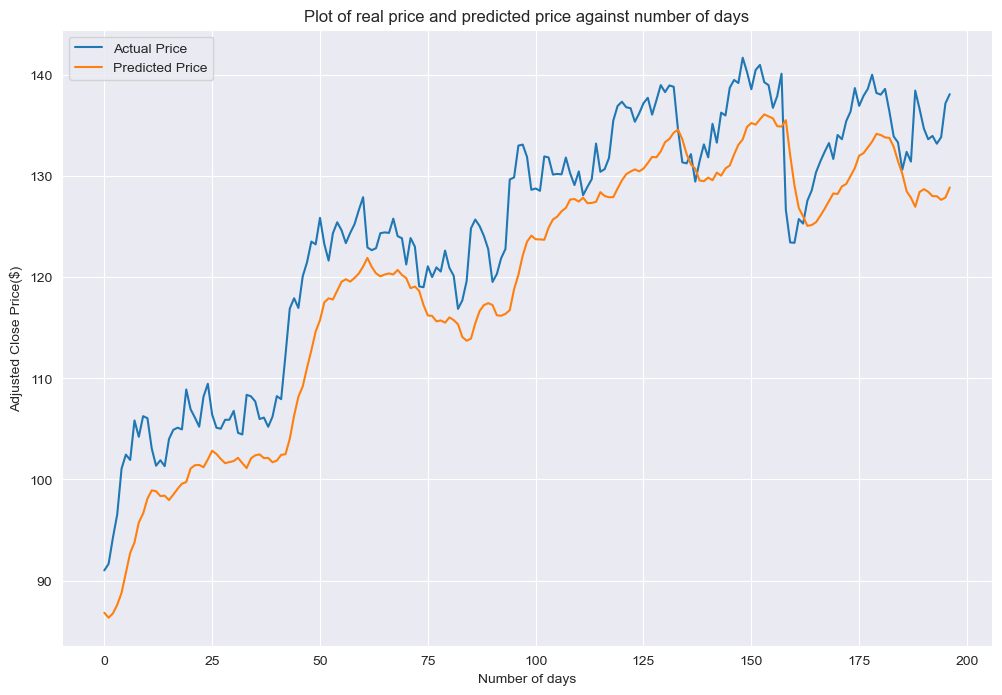

In [392]:
if __name__ == "__main__":
    #start_date = datetime(2013, 12, 20)
    #end_date = datetime(2023, 12, 20)
    
    train_split = 0.7
    
    history_points = 30
    
    new_df = obv(goog)

    new_df = add_technical_indicators(new_df)
    
    x_train, y_train, x_test, y_test, y_reverse_normaliser = train_test_split_preparation(new_df, train_split)

    model = lstm_model(x_train, y_train, history_points)

    y_pred = model.predict(x_test)
    y_pred = y_reverse_normaliser.inverse_transform(y_pred)

    real = plt.plot(y_test, label='Actual Price')
    pred = plt.plot(y_pred, label='Predicted Price')

    plt.gcf().set_size_inches(12, 8, forward=True)
    plt.title('Plot of real price and predicted price against number of days')
    plt.xlabel('Number of days')
    plt.ylabel('Adjusted Close Price($)')

    plt.legend(['Actual Price', 'Predicted Price'])
    
    print("RMSE: ")
    print(mean_squared_error(y_test, y_pred))
 
    plt.show() 

In [393]:
# Extract the last 'history_points' days of data
last_days = goog[-history_points:]

# Normalize the Input Data --> Same transformations as with the training data
normaliser = MinMaxScaler()
last_days_scaled = normaliser.fit_transform(last_days)

# Reshape the data to match the input shape of the LSTM model
x_to_predict = np.array([last_days_scaled])
x_to_predict = np.reshape(x_to_predict, (1, history_points, 6))

# Make the Prediction
predicted_stock_price = model.predict(x_to_predict)

# Inverse Transform the Prediction
predicted_stock_price = y_reverse_normaliser.inverse_transform(predicted_stock_price)

# Print the predicted stock price
print(goog.loc['2023-12-19', 'Adj Close'])
print("Predicted stock price for 2023-12-20:", predicted_stock_price[0,0])

1/1 [==============================] - 0s 8ms/step
138.10000610351562
Predicted stock price for 2023-12-20: 115.91653


/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/lennartmuller/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu